In [1]:
import os
import sys

import demo_tools as demo

In [24]:
cwd = os.getcwd()
if cwd.endswith(os.path.join("coloradar_plus_processing_tools", "coloradar_plus_processing_tools")):
    build_dir = os.path.join(cwd, "..", "build")
else:
    build_dir = os.path.join(cwd, "build")
sys.path.append(build_dir)
import coloradar_dataset_tools as ct

### Sensor Parameters

#### Lidar
- 0.01◦ angular accuracy
- angular resolution 0.35◦ horizontal
- 0.7◦ vertical
- 3cm range accuracy
- field of view 360◦ horizontal
- 45◦ vertical
- max range 120m

#### Single Chip Radar
- Range resolution 0.125m
- Max range 12m
- Doppler velocity resolution 0.04 m/s
- Max Doppler velocity 2.56 m/s
- Azimuth resolution 11.3◦
- Elevation resolution 45◦

#### Cascade Radar
- Range resolution 0.117m
- Max range 15m
- Doppler velocity resolution 0.254 m/s
- Max Doppler velocity 2.02 m/s
- Azimuth resolution 1.05◦
- Elevation resolution 22.5◦

### Initialize Dataset

In [25]:
COLORADAR_PATH = os.path.join(os.path.expanduser('~'), 'coloradar')
try:
    dataset = ct.ColoradarPlusDataset(COLORADAR_PATH)
except RuntimeError:
    dataset = ct.ColoradarDataset(COLORADAR_PATH)

In [26]:
run_name = dataset.list_runs()[0]
run = dataset.get_run(run_name)
run_name

'ec_hallways_run0'

In [27]:
true_timestamps = run.pose_timestamps()
radar_timestamps = run.cascade_timestamps()
true_timestamps.shape, radar_timestamps.shape

((985,), (520,))

In [28]:
# arrays of (x, y, z, qx, qy, qz, qw)
true_poses = run.get_poses()
radar_poses = run.interpolate_poses(true_poses, true_timestamps, radar_timestamps)
true_poses.shape, radar_poses.shape

((985, 7), (520, 7))

In [29]:
lidar_transform = dataset.lidar_transform()
radar_transform = dataset.cascade_transform()
lidar_transform.shape

(7,)

In [30]:
radar_config = dataset.cascade_config()
print('Max radar range: ', radar_config.num_range_bins * radar_config.range_bin_width)

Max radar range:  7.5896825790464


In [34]:
dataset.cascade_config()

128

### Plot Poses

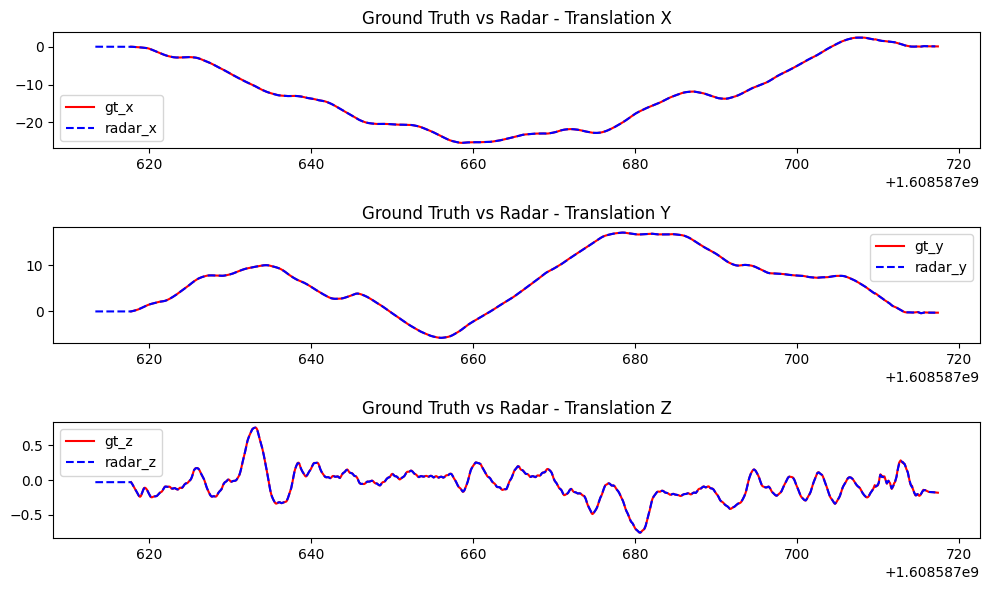

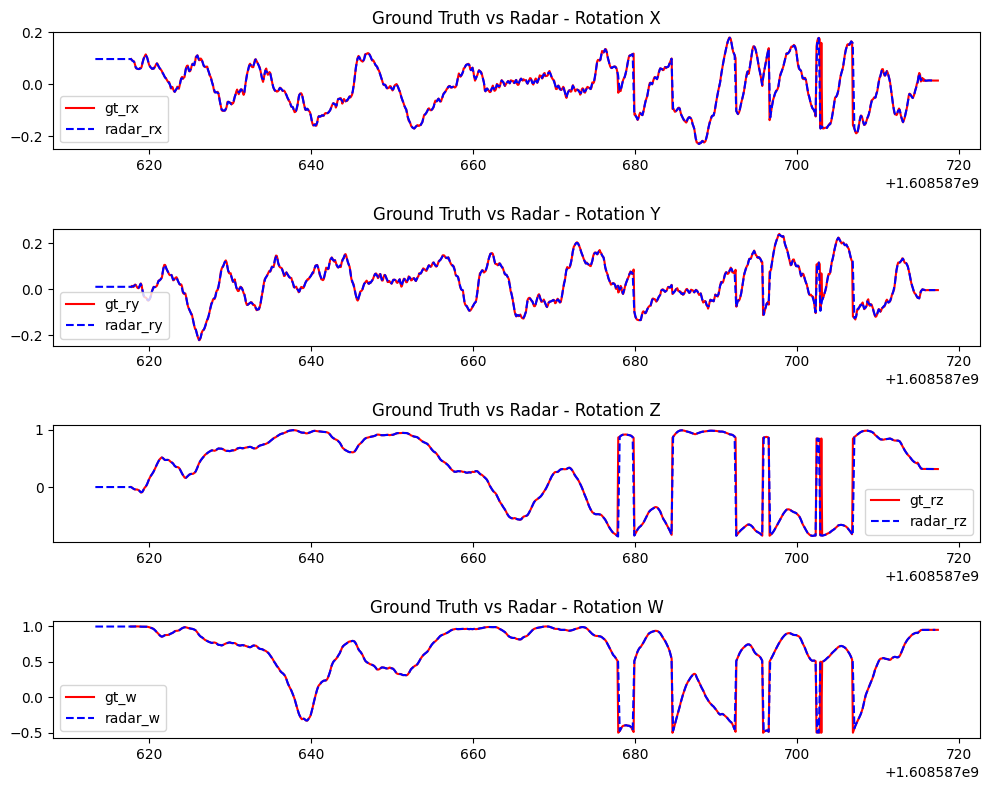

In [9]:
demo.plot_poses(true_timestamps, true_poses, radar_timestamps, radar_poses, 'radar')

### Build Lidar Octomap

In [ ]:
# this may take a while
run.create_lidar_octomap(map_resolution=0.25, lidar_total_horizontal_fov=360, lidar_total_vertical_fov=33.2, lidar_max_range=40, base_to_lidar_transform=lidar_transform)

In [13]:
map_pcl = run.get_lidar_octomap()
map_pcl.shape

(582042, 4)

In [14]:
demo.show_occupancy_pcl(map_pcl, prob_threshold=0.75)

### Show Radar FOV Options

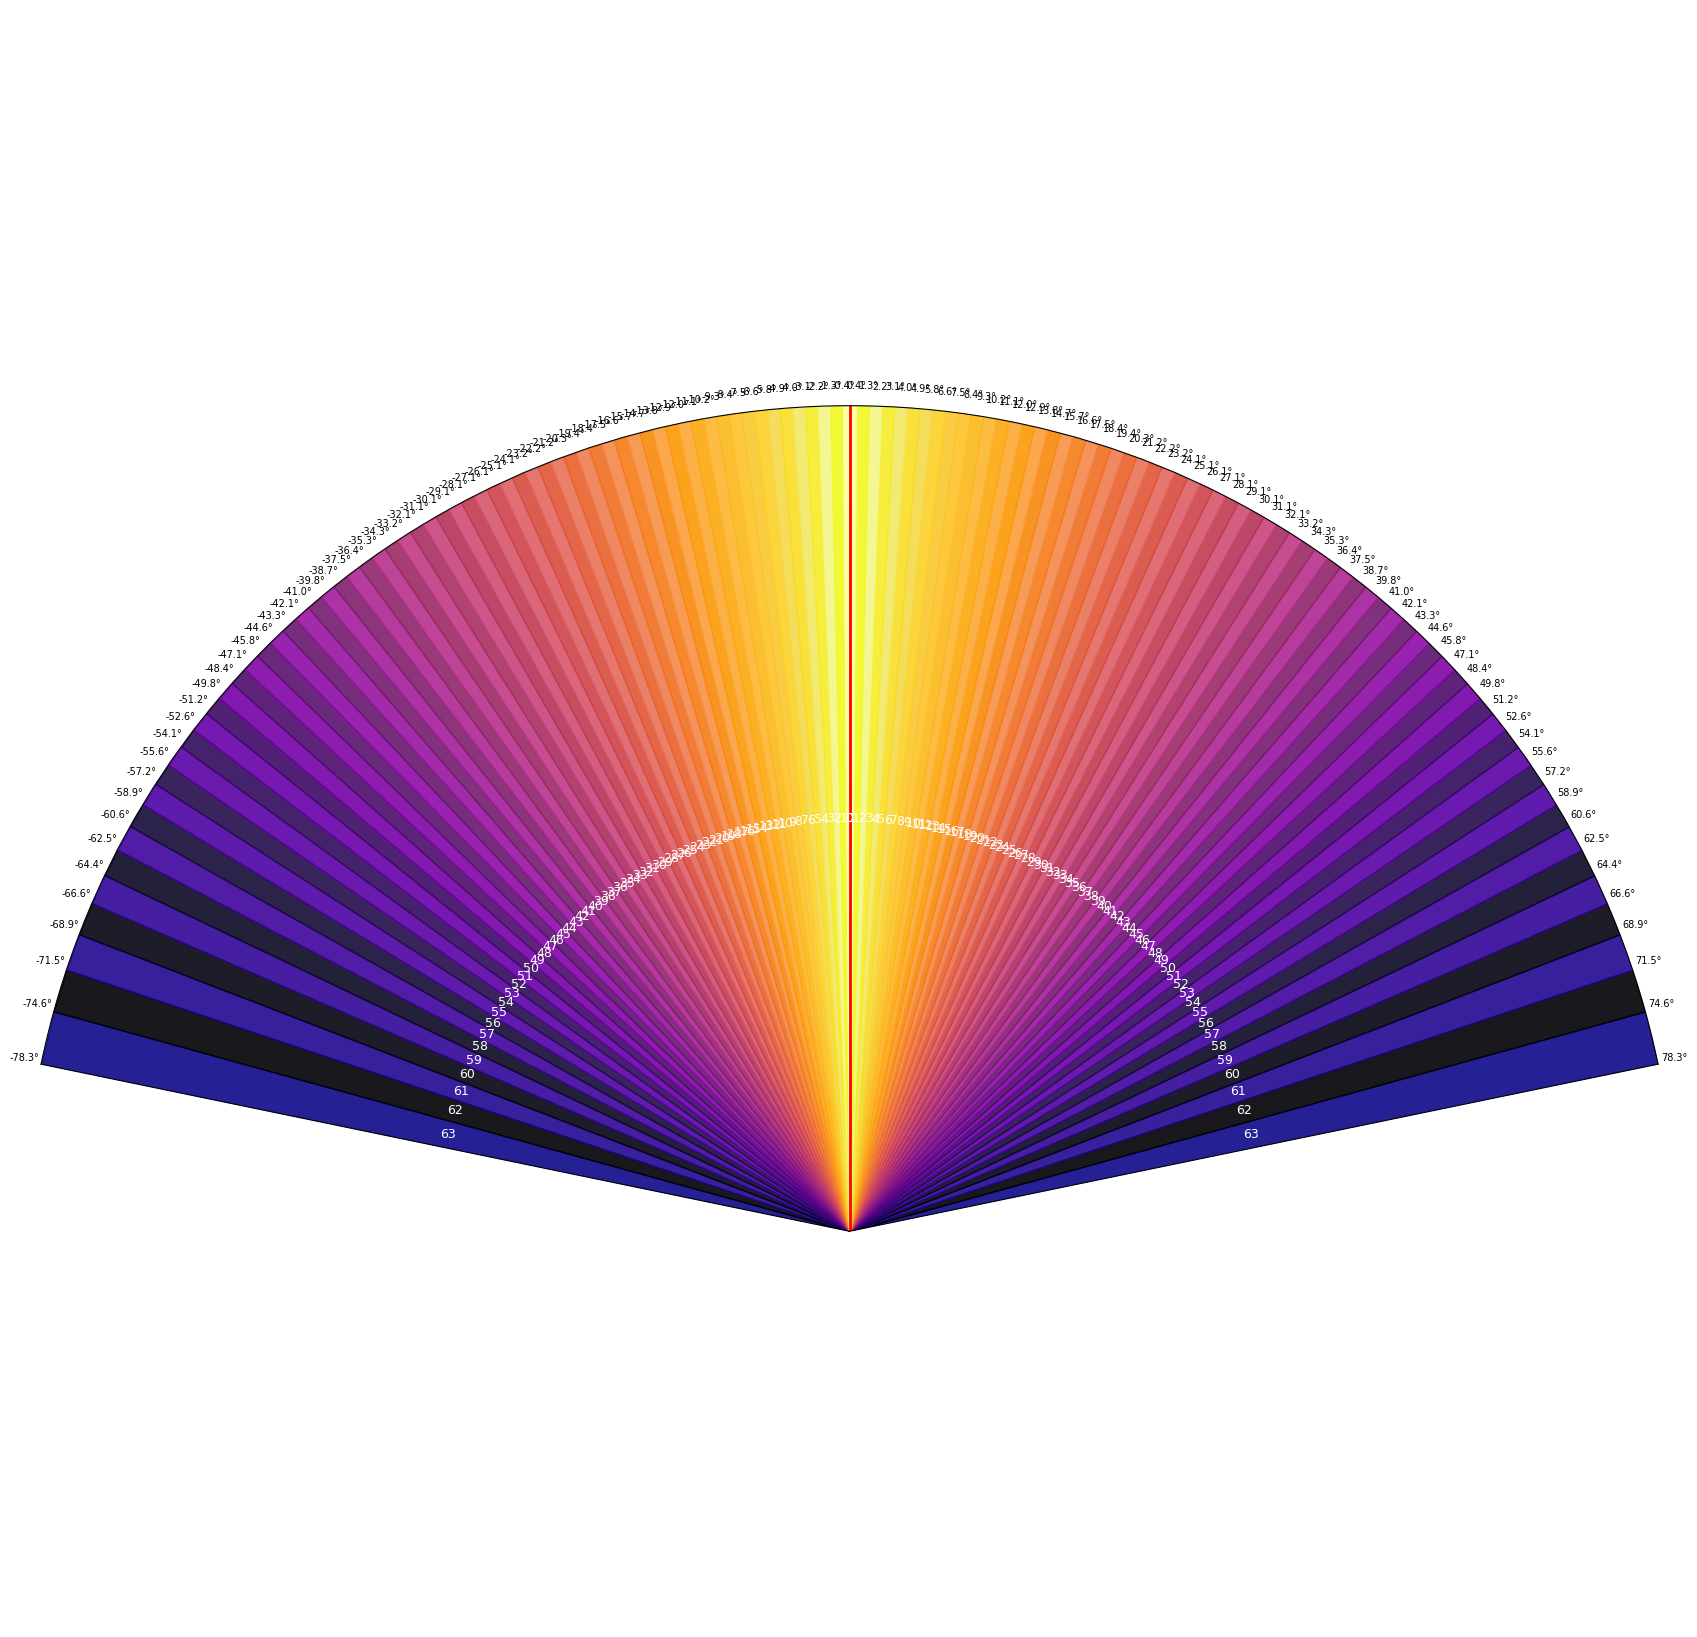

In [22]:
demo.display_azimuth_fov_options(radar_config)

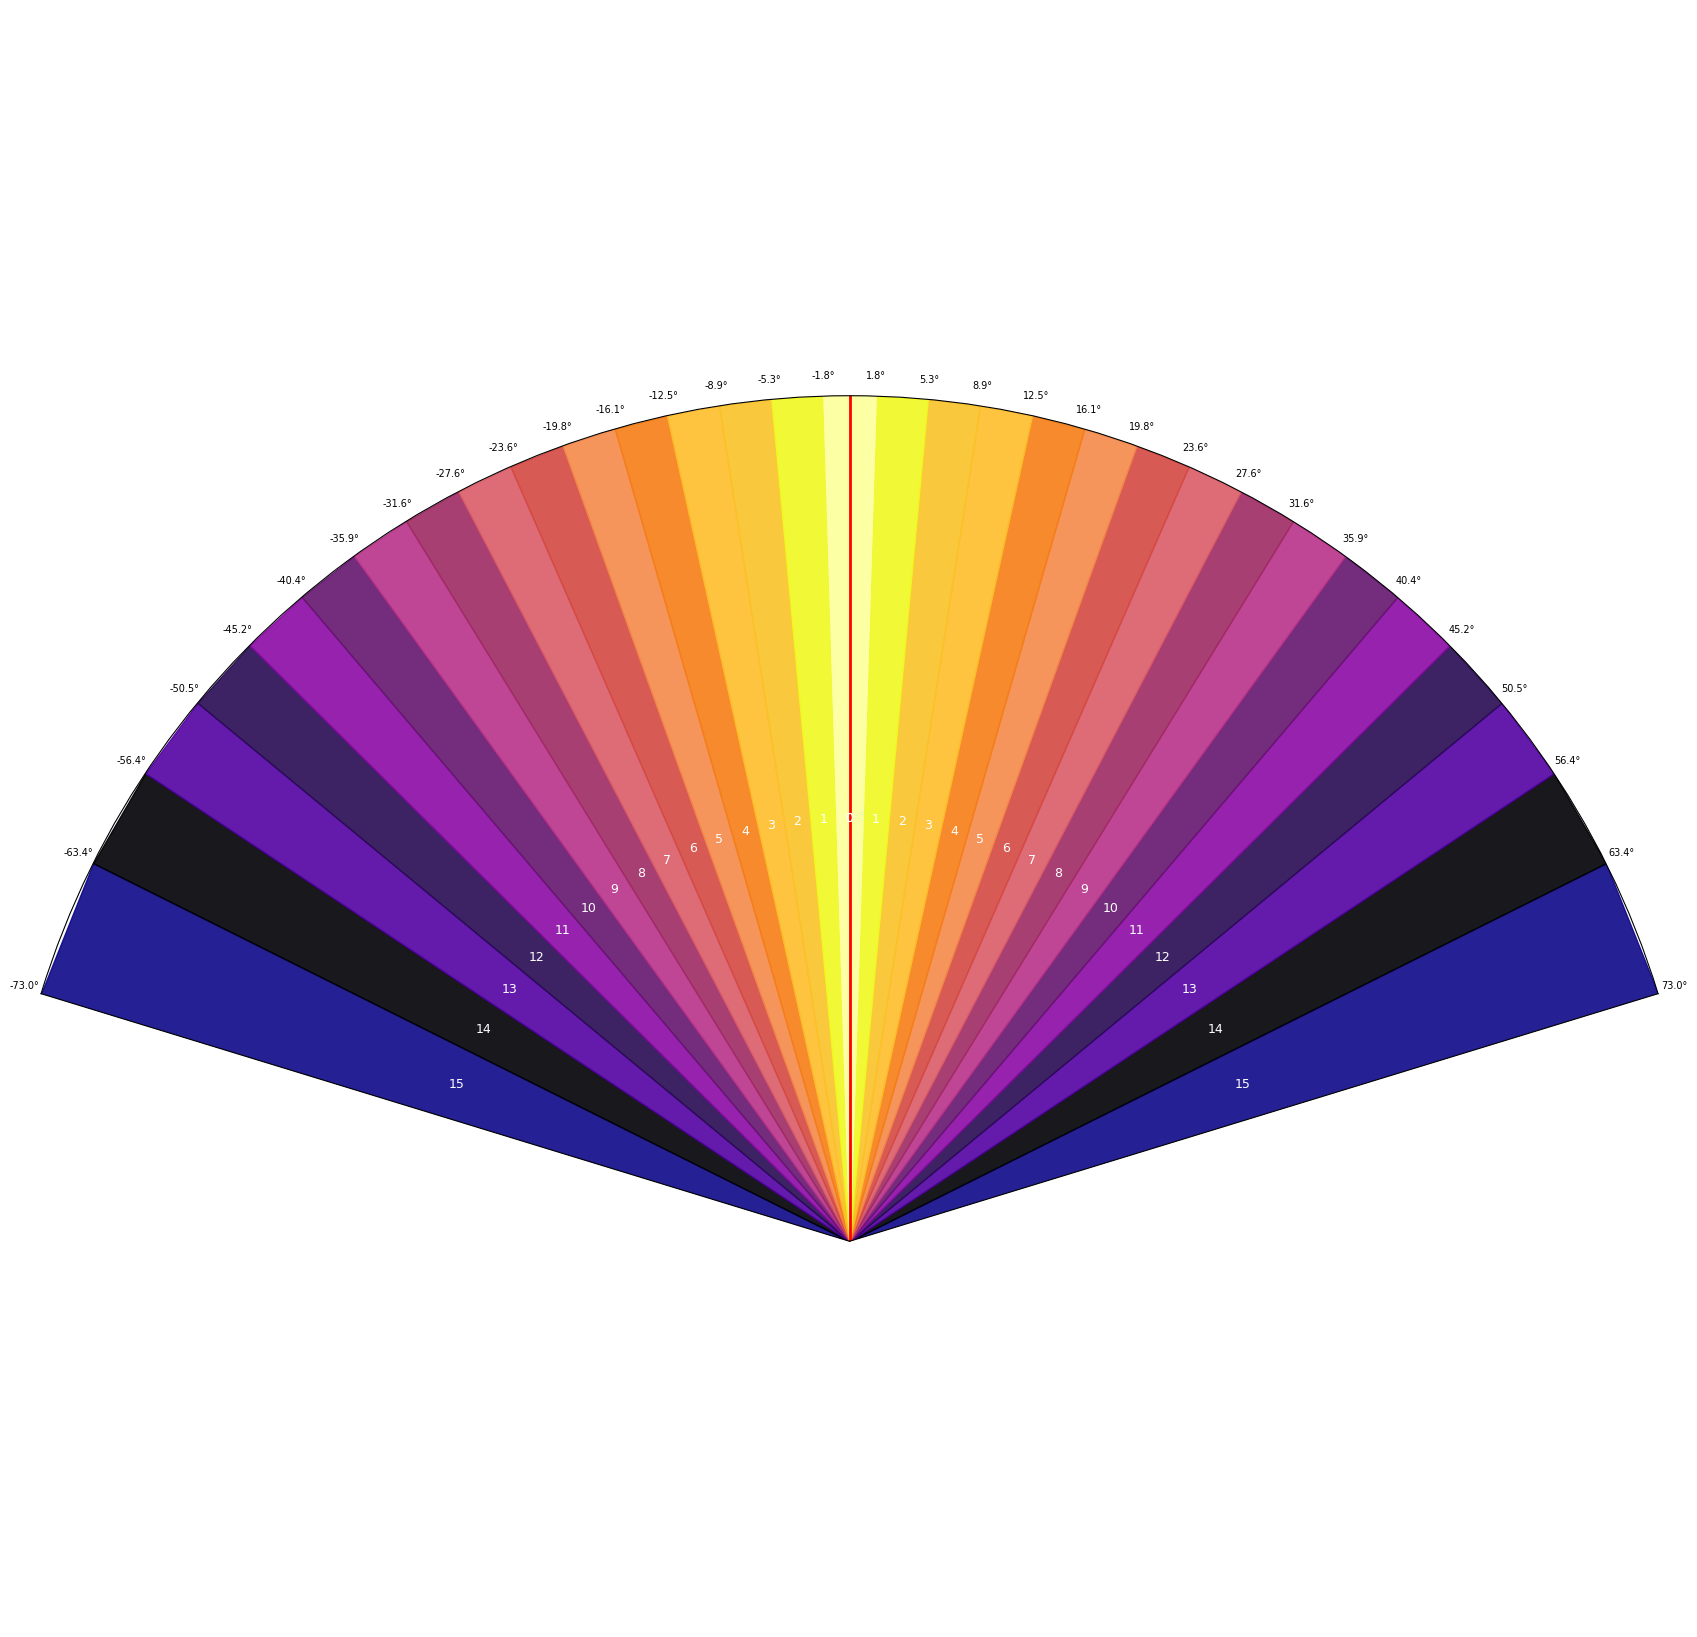

In [23]:
demo.display_elevation_fov_options(radar_config)

### Sample Lidar Map in Radar FOV

In [11]:
radar_fov_bins = {
    'azimuth_fov_idx': 63,
    'elevation_fov_idx': 4,
    'range_bin_idx': 117
}
radar_fov_params = demo.radar_bins_to_fov(radar_config, **radar_fov_bins)
radar_fov_params

{'total_horizontal_fov': 156.6, 'total_vertical_fov': 32.2, 'range': 7.0}

In [12]:
run.sample_map_frames(base_to_sensor_transform=radar_transform, base_poses=radar_poses, **radar_fov_params)

In [13]:
map_frame_0 = run.get_map_frame(350)

In [20]:
demo.show_occupancy_pcl(map_frame_0)

### Create Radar Pointclouds

In [28]:
# this may take a few minutes
run.create_cascade_pointclouds()

In [15]:
cloud = run.get_cascade_pointcloud(350)
cloud.shape

(15104, 5)

In [19]:
demo.show_radar_pcl(cloud, intensity_threshold_percent=5)

### Export

In [21]:
dataset_path = dataset.export_to_file(
    runs=[dataset.get_run('ec_hallways_run0'), dataset.get_run('edgar_classroom_run0')], 
    destination="dataset1.h5",
    include_cascade_heatmaps=True, cascade_azimuth_max_bin=63, cascade_elevation_max_bin=4, cascade_range_max_bin=117, remove_cascade_doppler_dim=True,
    include_cascade_pointclouds=False, cascade_pointclouds_in_global_frame=True,
    include_cascade_poses=True, include_cascade_timestamps=True,
    include_lidar_frames=False, include_lidar_map=True, include_map_frames=True, 
    collapse_map_elevation=False, collapse_map_sample_elevation=False, remove_lidar_intensity=True
)

[pcl::PCDReader::readHeader] number of points is zero.
[pcl::fromPCLPointCloud2] No data to copy.
[pcl::PCDReader::readHeader] number of points is zero.
[pcl::fromPCLPointCloud2] No data to copy.
[pcl::PCDReader::readHeader] number of points is zero.
[pcl::fromPCLPointCloud2] No data to copy.
[pcl::PCDReader::readHeader] number of points is zero.
[pcl::fromPCLPointCloud2] No data to copy.
[pcl::PCDReader::readHeader] number of points is zero.
[pcl::fromPCLPointCloud2] No data to copy.
[pcl::PCDReader::readHeader] number of points is zero.
[pcl::fromPCLPointCloud2] No data to copy.
[pcl::PCDReader::readHeader] number of points is zero.
[pcl::fromPCLPointCloud2] No data to copy.
[pcl::PCDReader::readHeader] number of points is zero.
[pcl::fromPCLPointCloud2] No data to copy.
[pcl::PCDReader::readHeader] number of points is zero.
[pcl::fromPCLPointCloud2] No data to copy.
[pcl::PCDReader::readHeader] number of points is zero.
[pcl::fromPCLPointCloud2] No data to copy.
[pcl::PCDReader::rea

In [22]:
dataset_path # = '/home/arpg/projects/coloradar_plus_processing_tools/coloradar_plus_processing_tools/exported_dataset.h5'

PosixPath('/home/arpg/projects/coloradar_plus_processing_tools/coloradar_plus_processing_tools/dataset1.h5')

In [23]:
data = demo.read_h5_dataset(dataset_path)
data.keys()

dict_keys(['cascade_heatmaps', 'lidar_map', 'lidar_map_frames', 'true_poses', 'cascade_poses', 'lidar_poses', 'true_timestamps', 'cascade_timestamps', 'lidar_timestamps'])

In [12]:
data['lidar_map']['edgar_classroom_run0'].shape

(255404, 4)

In [22]:
demo.show_occupancy_pcl(data['lidar_map'][run_name], 0.75)

In [13]:
data['cascade_heatmaps']['ec_hallways_run0'].shape

(520, 128, 118, 10)

In [23]:
len(data['lidar_map_frames']['ec_hallways_run0'][450])

5448

In [16]:
demo.show_occupancy_pcl(data['lidar_map_frames']['ec_hallways_run0'][519], 0.75)